In [1]:
#Package needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.signal import firwin, freqz
from numpy import fft
from pylab import MaxNLocator

    

In [2]:
#Simple function to convert unsigned number in signed
def convert_tosigned(x, nbits):
    if x >= 2**(nbits-1):
        x -= 2**nbits
    return x

0.1
FIR filter coefficients:  [0.03383324 0.24012702 0.45207947 0.24012702 0.03383324]


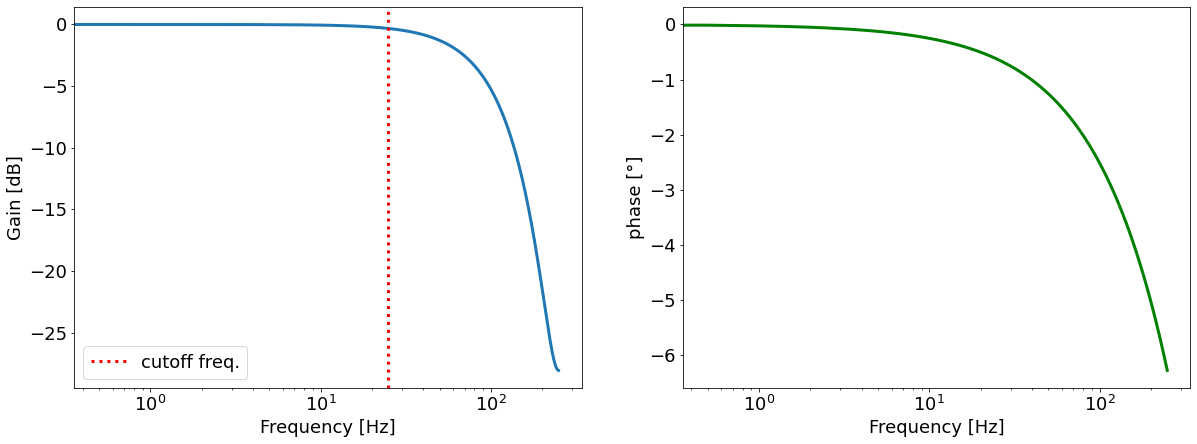

In [4]:
taps = 5
fcut = 0.1
print(fcut)
coeff = np.asarray(firwin(taps, fcut ))
print("FIR filter coefficients: ", coeff)

f, h = freqz(coeff, fs = 500)
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 7))
ax1.plot(f, 20*np.log10(abs(h)), lw = 3)
angles = np.unwrap(np.angle(h))
ax2.plot(f, angles, color = 'green', lw = 3)

ax1.set_xlabel('Frequency [Hz]', fontsize = 18)
ax1.set_ylabel('Gain [dB]', fontsize = 18)
#ax1.set_title('Frequency Response')
ax1.set_xscale('log')
ax1.axvline(x=25, color = 'red', ls = 'dotted', lw = 3, label = 'cutoff freq.')
ax1.legend(fontsize = 18)

ax2.set_xlabel('Frequency [Hz]', fontsize = 18)
ax2.set_ylabel('phase [°]', fontsize = 18)
#ax2.set_title('Phase Response')
ax2.set_xscale('log')

ax1.tick_params(labelsize=18)
ax2.tick_params(labelsize=18)

#!mkdir images_py

plt.savefig('images_py/Bode.png', dpi = 300)
plt.show()

0.1


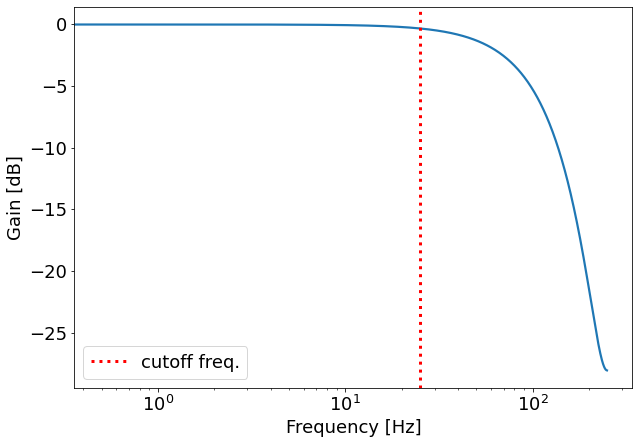

In [5]:

fcut = 0.1
print(fcut)
coeff = np.asarray(firwin(taps, fcut ))

f, h = freqz(coeff, fs = 500)
fig, ax1 = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 7))
ax1.plot(f, 20*np.log10(abs(h)), lw = 2.2)

ax1.set_xlabel('Frequency [Hz]', fontsize = 18)
ax1.set_ylabel('Gain [dB]', fontsize = 18)
ax1.set_xscale('log')
ax1.axvline(x=25, color = 'red', ls = 'dotted', lw = 3, label = 'cutoff freq.')
ax1.legend(fontsize = 18)

ax1.tick_params(labelsize=18)

plt.savefig('images_py/Bode_150.png', dpi = 300)
plt.show()

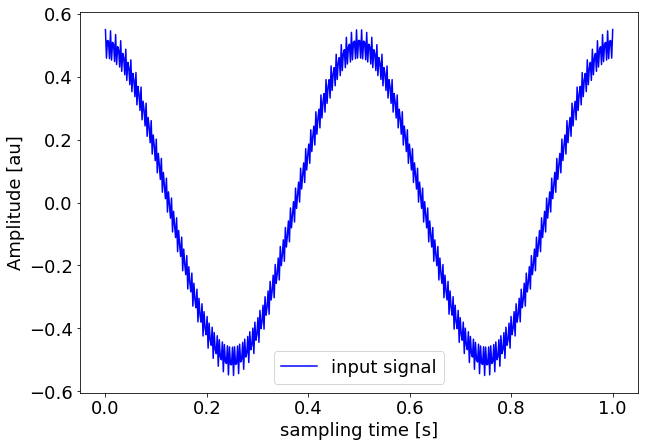

In [6]:
#Defining a noisy input signal
freq = 2
nf = 500
sampling = np.linspace(0, 1, nf)
freq_noise = 200
sig_no_noise = 0.5*np.cos(2*np.pi*freq*sampling)
noise = 0.05 * np.cos(2*np.pi*freq_noise*sampling)
sig = sig_no_noise + noise
plt.figure(figsize = (10, 7))
plt.plot(sampling, sig, label='input signal', c='blue')
plt.xlabel('sampling time [s]', fontsize = 18)
plt.legend(fontsize = 18)
plt.ylabel('Amplitude [au]', fontsize = 18)
plt.tick_params(labelsize=18)
plt.savefig('images_py/Input_signal.png', dpi = 300)
plt.show()

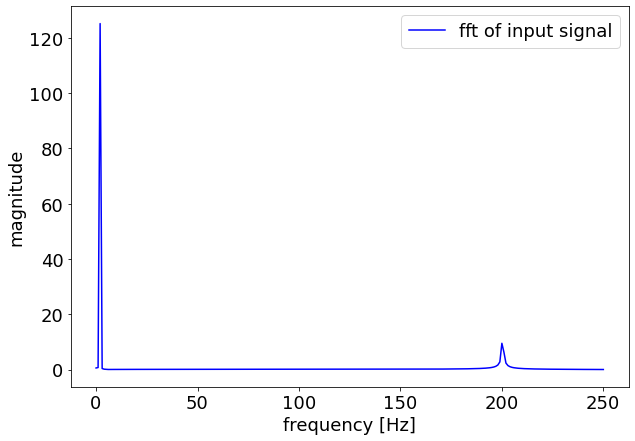

In [7]:
spectrum_sampl = fft.rfft(sig, nf)
freq_fourier = fft.rfftfreq(nf, d=1/nf)
plt.figure(figsize = (10, 7))
plt.xlabel('frequency [Hz]', fontsize = 18)
plt.ylabel('magnitude', fontsize = 18)
plt.plot(freq_fourier, np.abs(spectrum_sampl), label='fft of input signal', c='blue')
plt.legend(fontsize = 18)
plt.tick_params(labelsize=18)
plt.savefig('images_py/Input_signal_fft.png', dpi = 300)
plt.show()

In [8]:
#Write 'sig' to file with conversion to signed integer for the FPGA
ofile = open('input_signal.txt', 'w')
sig_uns = np.zeros_like(sig)
sig_bin = np.zeros_like(sig)
for i in range(sig.size):
    sig_bin[i] = int(sig[i]*2**7)
    sig_uns[i] = int(np.binary_repr(int(sig[i]*2**7), width = 8), 2)
    ofile.write(str(int(sig_uns[i])) + '\n')
ofile.close()

## IDEAL BEAHAVIOUR

In [9]:
index = int((taps-1)/2)
filt_sig = np.zeros_like(sig)
for i in range(sig.size-taps+1):
    filt_sig[i+index] = np.dot(sig[i:taps+i], coeff[::-1])


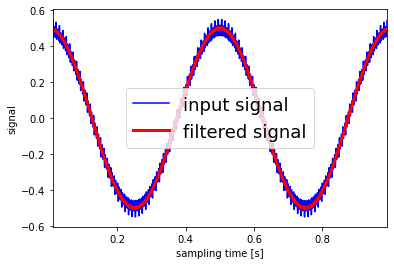

In [10]:
plt.plot(sampling, sig, c='blue', label='input signal')
plt.plot(sampling, filt_sig, c='r', label='filtered signal', lw = 3)
plt.xlim(0.01, 0.99)
plt.xlabel('sampling time [s]')
plt.ylabel('signal')
plt.legend(fontsize = 18)

plt.show()

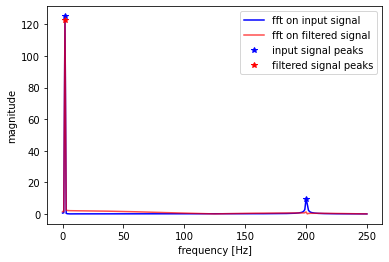

In [11]:
spectrum_filtered = fft.rfft(filt_sig, nf)
freq_filtered = fft.rfftfreq(nf, d=1/nf)



magnitude = np.abs(spectrum_sampl)
peaks, _ = scipy.signal.find_peaks(magnitude, height=5)

magnitude_filt = np.abs(spectrum_filtered)
peaks_filt, _ = scipy.signal.find_peaks(magnitude_filt, height=5)


plt.plot(freq_fourier, np.abs(spectrum_sampl), c='blue', label='fft on input signal')
plt.plot(freq_filtered, np.abs(spectrum_filtered), c='red', label='fft on filtered signal', alpha=0.7)
plt.plot(freq_fourier[peaks], magnitude[peaks], '*', label='input signal peaks', c='blue')
plt.plot(freq_filtered[peaks_filt], magnitude_filt[peaks_filt], '*', label='filtered signal peaks', c='r')
plt.legend(loc='best')
plt.xlabel('frequency [Hz]')
plt.ylabel('magnitude')
plt.show()

In [12]:
print('input signal frequency analysis')
for i in peaks:
    str0 = f'frequency at which the input signal dispays peaks: {freq_fourier[i]} magnitude {magnitude[i]}'
    print(str0)

print('filtered signal frequency analysis')
for i in peaks_filt:
    str0 = f'frequency at which the filtered signal dispays peaks: {freq_filtered[i]} magnitude {magnitude_filt[i]}'
    print(str0)

input signal frequency analysis
frequency at which the input signal dispays peaks: 2.0 magnitude 125.17183675828915
frequency at which the input signal dispays peaks: 200.0 magnitude 9.48971658018734
filtered signal frequency analysis
frequency at which the filtered signal dispays peaks: 2.0 magnitude 123.09623140078173


In [13]:
ofile = open('ideal_output_signal.txt', 'w')
filt_sig_bin = np.zeros_like(filt_sig)
for i in range(filt_sig.size):
    filt_sig_bin[i] = int(filt_sig[i]*2**7)
    ofile.write(str(filt_sig_bin[i]) + '\n')
ofile.close()

## SIMULATION

In [14]:
coeff_int = np.zeros_like(coeff)
coeff_bin = []

for i in range(taps):
    coeff_int[i] = (round(coeff[i]*2**7, 0))

for i in range(taps):
    coeff_bin.append(bin(int(coeff_int[i])))

print(coeff_int, '\n', coeff_bin)


[ 4. 31. 58. 31.  4.] 
 ['0b100', '0b11111', '0b111010', '0b11111', '0b100']


In [15]:
y = np.zeros_like(sig)
sim_filt_sig = np.zeros_like(sig_uns)
for i in range(sig_bin.size-taps+1):
    y[i+index] = np.dot(sig_bin[i:taps+i], coeff_int[::-1]) 
    bin_19 = np.binary_repr(int(y[i+index]), 19)
    bin_8 = bin_19[4:12]
    int_8 = int(bin_8, 2)
    sim_filt_sig[i+index] = convert_tosigned(int_8, 8)


In [16]:
df = pd.DataFrame()
df['Bin input uns'] = sig_uns
df['Bin input'] = sig_bin
df['Bin output'] = filt_sig_bin
df['Bin sim. output'] = sim_filt_sig

In [17]:
df.to_csv('Results.csv')

## Data from FPGA

(498,)
(2,)


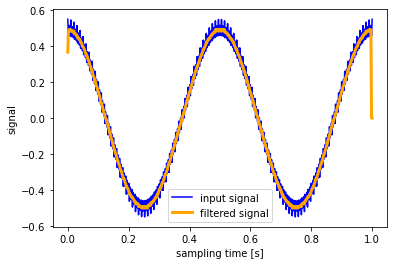

In [18]:
fpga_bin = np.loadtxt('output_signal.txt')
fpga = np.loadtxt('output_signal.txt')/2**7
print(fpga[2:].shape)
print(np.zeros(2).shape)
new = np.concatenate([fpga[2:], np.zeros(2)])
plt.plot(sampling, sig, c='blue', label='input signal')
plt.plot(sampling, new, c='orange', label='filtered signal', lw = 3)
#plt.xlim(0.01, 0.99)
plt.xlabel('sampling time [s]')
plt.ylabel('signal')
plt.legend(loc='best')
plt.show()

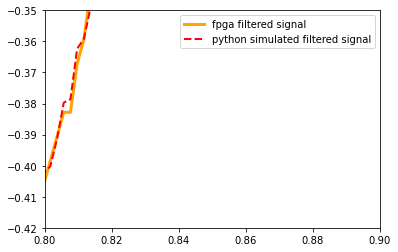

In [19]:
plt.plot(sampling, new, c='orange', label='fpga filtered signal', lw = 3)
plt.plot(sampling, filt_sig, c='r', label='python simulated filtered signal', lw = 2, ls = '--')
plt.xlim(0.8, 0.9)
plt.ylim(-0.42, -0.35)
plt.legend()
plt.show()

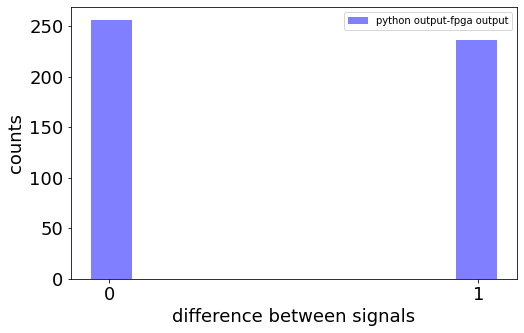

[256.   0.   0.   0.   0.   0.   0.   0.   0. 236.] [-0.05  0.06  0.17  0.28  0.39  0.5   0.61  0.72  0.83  0.94  1.05]
256.0 236.0


In [23]:
difference_true_fpga = filt_sig_bin[2:-2] - fpga_bin[4:]
difference_sim_fpga = sim_filt_sig/2**7 - new 

fig, ax = plt.subplots(1,1, figsize=(8, 5))
counts, bins, _ =  plt.hist(difference_true_fpga[2:-2], 
                            range= (-0.05, 1.05),bins=10, 
                            color='blue', alpha=0.5,
                           label='python output-fpga output')
#ax.set_title('difference between python ideal filtered signal and fpga filtered signal', fontsize = 18)
#ax.axvline(x=0, color = 'red', ls = 'dotted', lw = 3)
ax.set_xlabel('difference between signals', fontsize = 18)
#plt.legend(fontsize = 18)
ax.set_ylabel('counts', fontsize = 18)
ax.tick_params(labelsize=18)
ya = ax.get_xaxis()
ya.set_major_locator(MaxNLocator(integer=True))
plt.savefig('images_py/difference_histogram.png', dpi = 300)
plt.legend()

plt.show()

print(counts, bins)

under_0 = counts[:3].sum()
over_0 = counts[3:].sum()
print(under_0, over_0)

In [21]:
print((new))

[ 0.3671875  0.4765625  0.4921875  0.4921875  0.484375   0.4921875
  0.484375   0.484375   0.484375   0.4765625  0.484375   0.46875
  0.46875    0.46875    0.4609375  0.4609375  0.4453125  0.4453125
  0.4453125  0.4375     0.4375     0.421875   0.421875   0.4140625
  0.3984375  0.3984375  0.390625   0.3828125  0.375      0.359375
  0.359375   0.34375    0.34375    0.328125   0.3203125  0.3125
  0.296875   0.2890625  0.28125    0.265625   0.265625   0.2421875
  0.234375   0.2265625  0.2109375  0.2109375  0.1875     0.1796875
  0.171875   0.15625    0.1484375  0.1328125  0.125      0.109375
  0.09375    0.0859375  0.0703125  0.0625     0.046875   0.03125
  0.0234375  0.0078125  0.        -0.0078125 -0.0234375 -0.03125
 -0.046875  -0.0546875 -0.0703125 -0.0859375 -0.09375   -0.109375
 -0.1171875 -0.1328125 -0.1484375 -0.15625   -0.171875  -0.1796875
 -0.1953125 -0.203125  -0.2109375 -0.234375  -0.234375  -0.25
 -0.2578125 -0.265625  -0.28125   -0.2890625 -0.296875  -0.3125
 -0.3203125 -0.

In [22]:
print((filt_sig))

[ 0.          0.          0.5005801   0.4996878   0.494012    0.50010644
  0.49072752  0.49356658  0.49090229  0.4838263   0.48829261  0.47730747
  0.47875981  0.47436114  0.4659301   0.46881078  0.45627639  0.45639573
  0.4503247   0.44060776  0.44196932  0.42796643  0.42682993  0.41917203
  0.40826129  0.40819309  0.39282504  0.39053202  0.3813948   0.36940392
  0.36801671  0.35140784  0.34807818  0.3375896   0.32465203  0.32207611
  0.30436988  0.30014205  0.28844846  0.27471534  0.27109844  0.25245524
  0.24748405  0.23474787  0.22038569  0.21589057  0.19648526  0.19093937
  0.17733654  0.16252453  0.15732631  0.13734551  0.13140468  0.1171219
  0.10204923  0.09633257  0.0759718   0.069824    0.05505577  0.03991858
  0.0338747   0.01333534  0.00717372 -0.00788069 -0.02288238 -0.02905882
 -0.04957262 -0.05555287 -0.07069258 -0.08535799 -0.09147201 -0.11175649
 -0.11736126 -0.13238693 -0.14651771 -0.15237716 -0.17223212 -0.17727156
 -0.1919885  -0.2053918  -0.21081049 -0.23004235 -0.